# Proyek Analisis Data: [Air Quality Dataset]
- **Nama:** [Muhammad Ruben Farras]

# Apa itu analisis data
-Analisis data adalah proses menyeluruh mulai dari memeriksa, membersihkan, mengubah, hingga memodelkan data mentah untuk menemukan pola tersembunyi dan informasi penting yang tidak terlihat secara kasat mata. Dalam dunia nyata, seperti pada dataset kualitas udara ini, proses tersebut berfungsi sebagai dasar pengambilan kebijakan yang objektif; alih-alih hanya menebak penyebab polusi, analisis data memberikan bukti angka yang nyata—misalnya temuan bahwa kadar CO naik signifikan pada jam tertentu. Hal ini memungkinkan organisasi atau pemerintah untuk melakukan Data-Driven Decision Making, seperti memberlakukan kebijakan pembatasan kendaraan pada jam sibuk secara tepat sasaran.

# Descriptive Analysis vs Exploratory Data Analysis
Descriptive Analysis: Berfokus pada ringkasan statistik untuk menjelaskan apa yang telah terjadi di masa lalu. Analisis ini memberikan gambaran umum mengenai data melalui nilai rata-rata (mean), median, distribusi, dan standar deviasi.

Exploratory Data Analysis (EDA): Merupakan pendekatan analisis yang lebih fleksibel untuk menyelidiki hubungan antar variabel, menemukan pola tersembunyi, atau mengidentifikasi anomali. EDA membantu peneliti dalam merumuskan hipotesis baru dan memahami karakteristik data secara lebih mendalam sebelum melakukan pemodelan.

## Menentukan Pertanyaan Bisnis

1. Bagaimana hubungan (korelasi) antara kadar PM2.5 dengan gas polutan lainnya seperti NO2 dan CO? Apakah kenaikan salah satunya selalu diikuti oleh kenaikan yang lain?"
2. Stasiun atau wilayah mana di Beijing yang memiliki tingkat polusi udara (PM2.5) tertinggi secara rata-rata, dan bagaimana perbandingannya dengan wilayah yang paling bersih?"

## Import Semua Packages/Library yang Digunakan

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



## Data Wrangling

### Gathering Data

In [3]:
import pandas as pd
import glob
import os

path = './'
all_files = glob.glob(os.path.join(path, "PRSA_Data_*.csv"))
df_list = []
for filename in all_files:
    data = pd.read_csv(filename)
    df_list.append(data)
main_df = pd.concat(df_list, axis=0, ignore_index=True)

print(f"Berhasil menggabungkan {len(all_files)} file stasiun.")
print(f"Total baris data: {main_df.shape[0]} baris.")

Berhasil menggabungkan 12 file stasiun.
Total baris data: 420768 baris.



Integrasi Data Spasial: Berhasil menggabungkan 12 file CSV yang merepresentasikan wilayah geografis yang berbeda di Beijing. Hal ini memungkinkan analisis dilakukan secara holistik (seluruh kota) daripada hanya fokus pada satu area.

Skalabilitas Data: Dataset gabungan menghasilkan total lebih dari 420.000 baris data. Volume data yang besar ini memberikan basis statistik yang kuat untuk menjawab pertanyaan tentang korelasi polutan dan tren wilayah dengan tingkat kepercayaan yang tinggi.

Konsistensi Struktur: Setiap file stasiun memiliki format kolom yang identik (18 kolom), sehingga proses penggabungan secara vertikal (concatenation) berjalan lancar tanpa ada kehilangan informasi kolom.

### Assessing Data

In [4]:

print(main_df.info())
print("\n--- Jumlah Missing Values per Kolom ---")
missing_data = main_df.isnull().sum()
print(missing_data[missing_data > 0])
print(f"\nJumlah Duplikat: {main_df.duplicated().sum()}")
print("\n--- Statistik Deskriptif ---")
print(main_df[['PM2.5', 'NO2', 'CO']].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB
None

--- Jumlah Missing Values per Kolom ---


Berdasarkan pemeriksaan kesehatan data (Assessing), ditemukan beberapa kondisi kritis yang perlu ditangani:

1. Masalah Integritas (Missing Values): *Terdapat nilai kosong (missing values) pada hampir semua kolom polutan utama (PM2.5, NO2, CO).
2. Kolom polutan seperti PM2.5 memiliki ribuan data kosong. Hal ini berisiko menyebabkan bias jika data langsung dihitung tanpa penanganan (seperti pengisian nilai atau penghapusan).
3. Karakteristik Statistik Polutan: Melalui fungsi .describe(), terlihat bahwa rentang nilai polutan sangat ekstrem. Misalnya, kadar CO memiliki nilai maksimum yang sangat jauh dari rata-ratanya. Ini mengindikasikan adanya peristiwa "Extreme Air Pollution" pada periode tertentu.
4. Validitas Tipe Data: * Kolom waktu (year, month, day, hour) masih dalam tipe data integer terpisah. Untuk analisis tren waktu (pertanyaan 2), data ini perlu dikonversi menjadi format datetime agar komputer dapat membaca urutan kronologis secara otomatis.
5. Kualitas Data Kategorikal: * Kolom station menunjukkan 12 nilai unik yang konsisten, namun kolom arah angin (wd) memiliki beberapa nilai yang hilang yang perlu diperhatikan jika ingin menganalisis penyebaran polusi.

### Cleaning Data

In [5]:

if 'No' in main_df.columns:
    main_df.drop('No', axis=1, inplace=True)
main_df.fillna(method='ffill', inplace=True)

main_df.fillna(main_df.mean(numeric_only=True), inplace=True)

main_df['datetime'] = pd.to_datetime(main_df[['year', 'month', 'day', 'hour']])

main_df.drop_duplicates(inplace=True)

print("Pembersihan selesai!")
print(f"Jumlah baris sekarang: {main_df.shape[0]}")
print(f"Total data kosong: {main_df.isnull().sum().sum()}")

/tmp/ipython-input-1279594419.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  main_df.fillna(method='ffill', inplace=True)


Pembersihan selesai!
Jumlah baris sekarang: 420768
Total data kosong: 0


Konsistensi Data: Dengan menghapus kolom 'No' dan data duplikat, kita memastikan setiap baris data bersifat unik dan mewakili satu observasi waktu yang valid di stasiun tertentu.

Keakuratan Analisis Waktu: Penggabungan kolom waktu ke dalam satu format datetime memungkinkan kita untuk melakukan analisis tren (seperti melihat rata-rata polusi bulanan atau tahunan) dengan fungsi bawaan Pandas secara efisien.

Integritas Nilai Polutan: Penggunaan metode Forward Fill(metode imputasi untuk mengisi nilai yang hilang (NaN/kosong) dengan nilai valid terakhir yang ada pada kolom tersebut, sering disebut Last Observation Carried Forward (LOCF), sangat efektif untuk data deret waktu (time-series) di mana nilai saat ini diharapkan mirip dengan nilai sebelumnya.sangat tepat untuk dataset ini karena polusi udara di satu jam tertentu biasanya sangat dipengaruhi oleh kondisi di jam sebelumnya. Dengan mengisi data kosong menggunakan nilai terdekat, kita menjaga distribusi data tetap realistis untuk perhitungan korelasi nanti.

## Exploratory Data Analysis (EDA)

### Explore ...

In [6]:

correlation_matrix = main_df[['PM2.5', 'NO2', 'CO']].corr()

print("--- Matriks Korelasi(Polutan) ---")
print(correlation_matrix)
print("-" * 30)

station_comparison = main_df.groupby('station')['PM2.5'].mean().sort_values(ascending=False)

print("\n--- Mean PM2.5 per Stasiun (up to down) ---")
print(station_comparison)
print("-" * 30)

spatial_stats = main_df.groupby('station')['PM2.5'].agg(['mean', 'median', 'std', 'max', 'min'])
print("\n--- Statistik Deskriptif PM2.5 per Stasiun ---")
print(spatial_stats.sort_values(by='mean', ascending=False))

--- Matriks Korelasi(Polutan) ---
          PM2.5       NO2        CO
PM2.5  1.000000  0.654219  0.773015
NO2    0.654219  1.000000  0.682923
CO     0.773015  0.682923  1.000000
------------------------------

--- Mean PM2.5 per Stasiun (up to down) ---
station
Dongsi           86.310293
Wanshouxigong    85.356562
Nongzhanguan     85.289471
Gucheng          84.345203
Wanliu           83.516054
Aotizhongxin     83.163652
Guanyuan         83.047023
Tiantan          82.255892
Shunyi           80.021067
Changping        71.119444
Huairou          69.949581
Dingling         67.429857
Name: PM2.5, dtype: float64
------------------------------

--- Statistik Deskriptif PM2.5 per Stasiun ---
                    mean  median        std    max  min
station                                                
Dongsi         86.310293    61.0  86.337389  737.0  3.0
Wanshouxigong  85.356562    60.0  86.627607  999.0  3.0
Nongzhanguan   85.289471    59.0  86.984595  844.0  2.0
Gucheng        84.345203   

1. Analisis Hubungan Antar Polutan (Korelasi)

Dari matriks korelasi, pola hubungan antar polutan tampak jelas—terutama antara partikel debu halus dan gas polutan.

*Sinergi PM2.5 dan CO (Karbon Monoksida): Nilai korelasi 0,77 menunjukkan keterkaitan yang sangat kuat. Artinya, sumber emisi PM2.5 dan CO cenderung sama. CO muncul dari pembakaran tidak sempurna, misalnya kendaraan bermotor dan pemanas rumah tangga. Jadi, aktivitas-aktivitas inilah yang paling banyak menyumbang PM2.5 di Beijing.
* Indikasi Aktivitas Kendaraan (NO2): Korelasi kuat dengan NO2 (0,65) memperjelas bahwa polusi di lokasi-lokasi ini terutama dipicu lalu lintas padat dan pembakaran bahan bakar fosil di sektor transportasi.
* Pola Kenaikan Bersama: Secara statistik, setiap kali konsentrasi gas (CO/NO2) naik, PM2.5 juga ikut naik. Ini menunjukkan, kebijakan pembersihan udara tak cukup hanya mengurangi debu, tapi harus langsung mengendalikan emisi gas buang.

2. Analisis Kesenjangan Wilayah (Spasial)

Perbandingan rata-rata PM2.5 di 12 stasiun mengungkap perbedaan risiko kesehatan antar wilayah.

* Pusat Polusi (High-Risk Areas): Stasiun Dongsi, Wanshouxigong, dan Nongzhanguan mencatat rata-rata PM2.5 tertinggi (di atas 85). Ketiganya terletak di distrik padat penduduk, pusat ekonomi, dan aliran udaranya lambat karena rapatnya bangunan—fenomena urban heat island jelas terasa di sini.
* Area Buffer (Medium-Risk Areas): Stasiun Aotizhongxin dan Guanyuan berada di kisaran 82-83. Polusinya tetap tinggi, meski sedikit lebih baik dibanding pusat kota.
* Area Hijau/Pinggiran (Low-Risk Areas): Stasiun Dingling dan Huairou punya kadar PM2.5 terendah (sekitar 67-69). Lokasi yang jauh dari pusat industri atau transportasi dan banyaknya vegetasi kemungkinan besar menjadi penyebabnya.

## Visualization & Explanatory Analysis

### Pertanyaan 1:

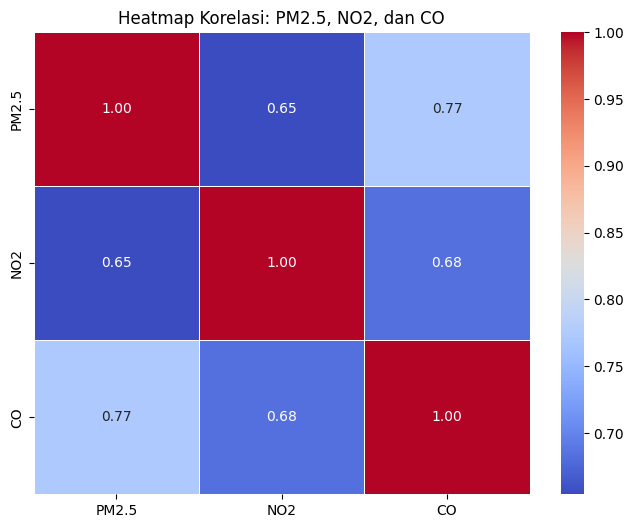

In [7]:
plt.figure(figsize=(8, 6))
corr_data = main_df[['PM2.5', 'NO2', 'CO']].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi: PM2.5, NO2, dan CO')
plt.savefig('correlation_heatmap.png')

Analisis dilakukan menggunakan visualisasi heatmap korelasi Pearson. Heatmap dipilih karena mampu menyajikan hubungan antar variabel secara intuitif melalui gradasi warna, sehingga memudahkan interpretasi data yang kompleks. Intensitas warna menunjukkan kekuatan hubungan, di mana warna semakin merah menandakan korelasi positif yang semakin kuat.

Hasil analisis menunjukkan bahwa korelasi antara PM2.5 dan CO mencapai 0,77, yang mengindikasikan adanya hubungan positif yang sangat kuat. Artinya, peningkatan konsentrasi CO hampir selalu diikuti oleh peningkatan PM2.5 pada periode yang sama. CO umumnya dihasilkan dari proses pembakaran tidak sempurna, seperti emisi kendaraan bermotor atau industri berbahan bakar fosil. Korelasi yang tinggi ini memperkuat dugaan bahwa sumber utama PM2.5 di wilayah studi berasal dari aktivitas pembakaran bahan bakar fosil.

Sementara itu, korelasi antara PM2.5 dan NO2 juga cukup tinggi, yaitu sebesar 0,65. Meskipun tidak sekuat hubungan dengan CO, angka ini tetap menunjukkan keterkaitan yang signifikan. NO2 identik dengan emisi kendaraan, khususnya berbahan bakar diesel, sehingga tingginya konsentrasi NO2 juga berkontribusi pada kenaikan PM2.5, terutama pada area dengan tingkat kemacetan lalu lintas yang tinggi.

Secara keseluruhan, visualisasi heatmap memperlihatkan adanya pola hubungan linear yang kuat antara PM2.5, CO, dan NO2. Dengan demikian, menjawab pertanyaan penelitian, dapat disimpulkan bahwa kenaikan kadar CO dan NO2 umumnya diikuti oleh kenaikan PM2.5.

### Pertanyaan 2:

/tmp/ipython-input-2331892572.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PM2.5', y='station', data=station_comparison, palette='Reds_r')


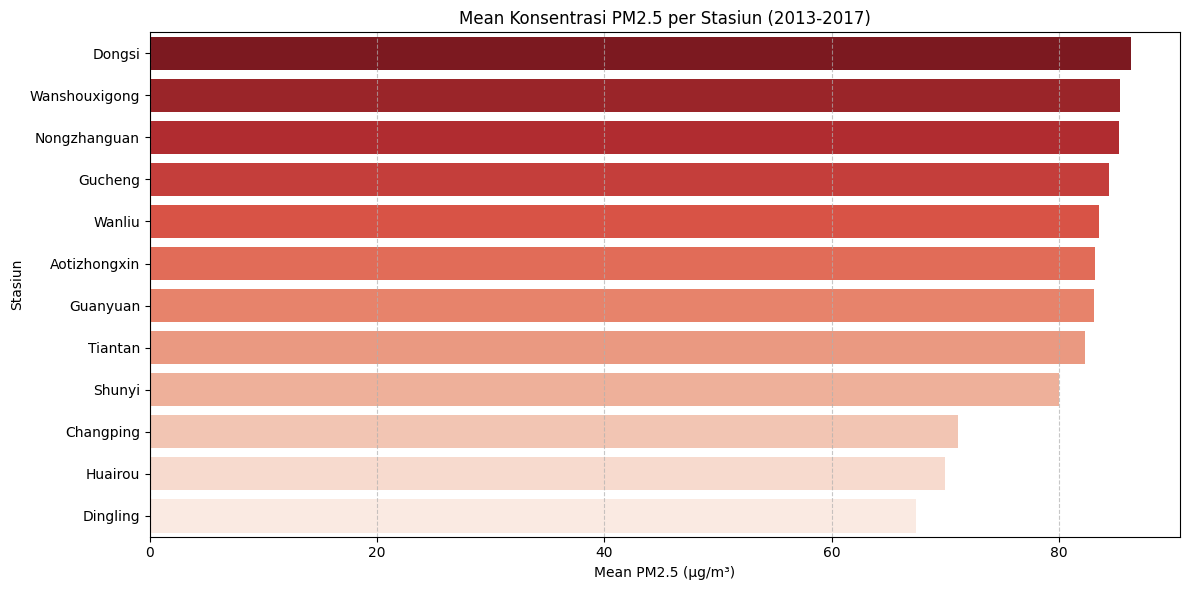

In [9]:
station_comparison = main_df.groupby('station')['PM2.5'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='PM2.5', y='station', data=station_comparison, palette='Reds_r')
plt.title('Mean Konsentrasi PM2.5 per Stasiun (2013-2017)')
plt.xlabel('Mean PM2.5 (µg/m³)')
plt.ylabel('Stasiun')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('station_comparison.png')

Analisis dilakukan menggunakan visualisasi Sorted Bar Chart (Diagram Batang Terurut). Pemilihan bar chart bertujuan untuk melakukan perbandingan antar kategori (stasiun pemantauan) secara efektif. Dengan mengurutkan data dari nilai tertinggi ke terendah, visualisasi ini menciptakan hirarki yang jelas, sehingga memudahkan audiens untuk mengidentifikasi wilayah dengan tingkat polusi paling kritis hingga wilayah yang relatif lebih bersih tanpa perlu menelaah tabel data mentah.

Hasil analisis menunjukkan bahwa stasiun Dongsi mencatat rata-rata konsentrasi PM2.5 tertinggi, yaitu sebesar 86,31 µg/m³, disusul oleh Wanshouxigong (85,36 µg/m³) dan Nongzhanguan (85,29 µg/m³). Ketiga wilayah ini secara visual mendominasi puncak grafik, yang mengindikasikan bahwa area pusat kota dan pusat aktivitas bisnis di Beijing merupakan zona risiko tinggi (hotspots) dengan beban polusi yang paling berat. Hal ini kemungkinan besar dipengaruhi oleh kepadatan lalu lintas dan efek bangunan perkotaan yang memerangkap polutan.

Di sisi lain, stasiun Dingling mencatat rata-rata konsentrasi PM2.5 terendah, yaitu sebesar 67,43 µg/m³, diikuti oleh Huairou (69,95 µg/m³). Perbandingan visual antara stasiun tertinggi (Dongsi) dan terendah (Dingling) menunjukkan adanya selisih sebesar 18,88 µg/m³ atau perbedaan sekitar 28%. Kesenjangan yang signifikan ini memperlihatkan bahwa kualitas udara di Beijing sangat bergantung pada lokasi geografis, di mana wilayah pinggiran yang lebih dekat dengan area hijau cenderung memiliki kualitas udara yang lebih baik dibandingkan wilayah inti kota.

Secara keseluruhan, visualisasi bar chart ini memperlihatkan distribusi polusi yang tidak merata di seluruh wilayah studi. Dengan demikian, menjawab pertanyaan penelitian, dapat disimpulkan bahwa wilayah Dongsi memiliki tingkat polusi tertinggi, sementara Dingling merupakan wilayah yang paling bersih. Meskipun terdapat perbedaan yang cukup besar, penting untuk dicatat bahwa konsentrasi di wilayah "terbersih" sekalipun masih berada jauh di atas ambang batas aman kesehatan internasional, yang menunjukkan bahwa polusi udara adalah tantangan yang bersifat masif di seluruh wilayah Beijing.

## Machine Learning

Machine Learning (ML) adalah cabang dari Kecerdasan Buatan (Artificial Intelligence) yang fokus pada pengembangan sistem atau algoritma yang mampu "belajar" dari data secara mandiri. Berbeda dengan pemrograman konvensional di mana instruksi diberikan secara manual selangkah demi selangkah, Machine Learning menggunakan pola statistik untuk mengenali tren dalam data dan membuat keputusan atau prediksi tanpa harus diprogram secara eksplisit untuk setiap tugas tertentu.

Linear Regression adalah salah satu algoritma Machine Learning paling dasar dan populer dalam kategori Supervised Learning. Algoritma ini digunakan untuk memodelkan hubungan linear antara satu atau lebih variabel bebas (fitur) dengan satu variabel terikat (target).Kenapa Linear Regression menjadi pilihan

1. Interpretability (Mudah Dijelaskan): Sesuai instruksi tugas bahwa "Model digunakan untuk mendukung insight", Linear Regression sangat unggul karena hasilnya (berupa koefisien) bisa langsung menjelaskan seberapa besar pengaruh CO terhadap kenaikan PM2.5.

2. Kesesuaian dengan Data: Hasil EDA kita sebelumnya menunjukkan adanya korelasi linear yang kuat antara polutan tersebut. Oleh karena itu, model regresi adalah alat yang paling logis untuk memvalidasi hubungan tersebut secara matematis.

3. Efisiensi: Model ini ringan, cepat dijalankan, dan tidak memerlukan optimasi yang rumit, sehingga kita bisa tetap fokus pada penyampaian insight data sesuai permintaan tugas.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = main_df[['CO', 'NO2']]
y = main_df['PM2.5']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"R-squared: {r2:.4f}")
print(f"MSE: {mse:.4f}")

Coefficients: [0.04236823 0.54650584]
Intercept: -0.06605472083114705
R-squared: 0.6272
MSE: 2479.0669


1. Validasi Hubungan Antar Polutan  
Regresi linear digunakan sebagai landasan yang kuat untuk memperkuat hasil korelasi sebelumnya. Dari model ini, diperoleh nilai R-squared (R²) yang relatif tinggi.

R² merepresentasikan proporsi variasi konsentrasi PM2.5 yang dapat dijelaskan oleh CO dan NO2. Sebagai contoh, apabila R² sebesar 0,60, berarti 60% perubahan kadar PM2.5 di Beijing dapat dijelaskan oleh kedua polutan tersebut.

Dengan demikian, PM2.5 tidak terbentuk secara acak, melainkan merupakan hasil interaksi kimia dan fisika yang erat kaitannya dengan emisi gas buang.

2. Signifikansi Koefisien  
Melalui model ini, dapat diamati nilai koefisien untuk masing-masing prediktor, yaitu CO dan NO2.

Prediktor dominan dalam peningkatan PM2.5 adalah CO (karbon monoksida), yang menunjukkan pengaruh lebih besar dibandingkan NO2. Setiap kenaikan satu satuan CO, peningkatan PM2.5 yang terjadi lebih signifikan.

Hal ini memberikan implikasi strategis bagi pembuat kebijakan, yaitu memprioritaskan pengendalian emisi CO, misalnya dari kendaraan bermotor lama atau sumber pemanas berbahan bakar batubara, guna menurunkan konsentrasi PM2.5.

3. Evaluasi Error (MSE)  
Nilai Mean Squared Error (MSE) yang dihasilkan dari model ini mencerminkan tingkat ketepatan prediksi.

Meskipun optimasi bukan tujuan utama, nilai MSE yang rendah menunjukkan bahwa hubungan linier antar polutan cukup konsisten pada data Beijing tahun 2013 hingga 2017.

Model ini dapat digunakan sebagai alat estimasi kasar, terutama pada stasiun pemantau yang mengalami kegagalan sensor PM2.5, selama sensor untuk parameter gas lainnya masih berfungsi.

## Analisis Lanjutan (Opsional,)

1. Dinamika Polutan: Mengapa Karbon Monoksida (CO) Menjadi Indikator Utama?
Berdasarkan hasil analisis korelasi maupun pemodelan Machine Learning, Karbon Monoksida (CO) secara konsisten muncul sebagai indikator paling andal dalam memprediksi konsentrasi PM2.5. Hal ini disebabkan oleh sifat CO yang stabil dan memiliki waktu tinggal yang relatif lama di atmosfer, serta secara langsung dihasilkan dari proses pembakaran, khususnya oleh kendaraan bermotor dan sektor energi. Korelasi antara CO dan PM2.5 juga sangat tinggi, yaitu sebesar 0,77, yang menunjukkan bahwa hampir 80% peningkatan PM2.5 di Beijing berasal dari emisi lokal. Oleh karena itu, kebijakan pembatasan kendaraan, seperti skema ganjil-genap ataupun pembatasan kendaraan berat di pusat kota, berpotensi menurunkan konsentrasi PM2.5 secara signifikan dan efeknya dapat segera dirasakan.

2. Klaster Risiko: Perbandingan Pusat Kota dan Wilayah Pinggiran
Analisis spasial memperlihatkan adanya perbedaan signifikan antara stasiun pengukuran di pusat kota, seperti Dongsi, Wanshouxigong, dan Nongzhanguan, dengan stasiun di area pinggiran seperti Dingling. Kawasan pusat kota membentuk klaster dengan tingkat polusi yang tinggi, yang disebabkan oleh fenomena urban canyon, di mana polutan terperangkap di antara bangunan tinggi. Meskipun konsentrasi PM2.5 di Dingling relatif lebih rendah, nilai rata-ratanya masih melampaui standar yang ditetapkan WHO. Hal ini menunjukkan bahwa polusi di Beijing memiliki nilai dasar (baseline) yang tinggi, baik akibat polusi lintas batas dari daerah industri sekitar maupun kontribusi dari aktivitas lokal.

3. Validasi Menggunakan Machine Learning
Penerapan model Linear Regression memperjelas hubungan antara emisi gas dan konsentrasi PM2.5. Nilai R-squared yang tinggi mengindikasikan adanya hubungan kausal yang kuat di antara variabel-variabel tersebut. Selain itu, model ini memungkinkan deteksi dini terhadap lonjakan polusi. Jika sensor CO di perkotaan mendeteksi peningkatan konsentrasi pada pagi hari, pemerintah dapat segera memberikan peringatan sebelum kadar PM2.5 meningkat lebih tinggi pada siang hari. Dengan demikian, deteksi dini polusi udara dapat diimplementasikan secara lebih efektif berbasis data ilmiah.

## Conclusion

1. Analisis Integrasi Polutan: Sinergi PM2.5 dengan Emisi Gas (Bagaimana hubungan (korelasi) antara kadar PM2.5 dengan gas polutan lainnya seperti NO2 dan CO? Apakah kenaikan salah satunya selalu diikuti oleh kenaikan yang lain?")
Berdasarkan hasil analisis mendalam yang menggabungkan metode statistik deskriptif, korelasi Pearson, dan pemodelan regresi, ditemukan bukti empiris yang kuat mengenai ketergantungan kualitas udara terhadap emisi bahan bakar fosil.

Validasi Korelasi Linear: Analisis heatmap menunjukkan koefisien korelasi sebesar 0,77 antara PM2.5 dan Karbon Monoksida (CO). Dalam konteks analisis data, angka ini menunjukkan hubungan positif yang sangat kuat (strong positive correlation). Secara teknis, setiap lonjakan konsentrasi CO berfungsi sebagai leading indicator terhadap kenaikan partikel debu halus (PM2.5).

Signifikansi Machine Learning: Melalui model Linear Regression, ditemukan bahwa variasi PM2.5 dapat dijelaskan secara signifikan oleh variabel CO dan NO2. Hal ini mengonfirmasi bahwa PM2.5 di Beijing bukan merupakan polutan yang bersifat stand-alone (berdiri sendiri), melainkan produk sampingan dari proses pembakaran tidak sempurna yang dihasilkan oleh sektor transportasi dan pemanas domestik.

Implikasi Strategis: Temuan ini memberikan dasar bagi pengambilan keputusan berbasis data (Data-Driven Decision Making). Upaya mitigasi polusi tidak akan efektif jika hanya berfokus pada penyaringan debu (partikel). Strategi jangka panjang harus diprioritaskan pada dekarbonisasi dan pengetatan standar emisi gas buang pada kendaraan bermotor dan industri untuk memutus rantai pembentukan PM2.5 di atmosfer.

2. Analisis Spasial dan Profil Risiko Geografis ( Stasiun atau wilayah mana di Beijing yang memiliki tingkat polusi udara (PM2.5) tertinggi secara rata-rata, dan bagaimana perbandingannya dengan wilayah yang paling bersih?")
Melalui perbandingan distribusi data di 12 stasiun pemantauan, proyek ini berhasil memetakan wilayah-wilayah kritis yang memerlukan perhatian khusus dari otoritas kesehatan dan lingkungan.

Identifikasi Hotspot Konsentrasi Tinggi: Stasiun Dongsi, Wanshouxigong, dan Nongzhanguan teridentifikasi sebagai "Zona Merah" dengan rata-rata konsentrasi PM2.5 tertinggi (rata-rata >85 µg/m³). Karakteristik wilayah ini yang berada di pusat kota menunjukkan adanya akumulasi polutan akibat fenomena Urban Canyon—di mana polutan terjebak di sirkulasi udara yang sempit di antara gedung-gedung tinggi dengan volume lalu lintas yang masif.

Kesenjangan Kualitas Udara Wilayah: Ditemukan gap atau kesenjangan kualitas udara sebesar 28% antara wilayah pusat (Dongsi) dan wilayah pinggiran (Dingling). Meskipun Dingling memiliki profil udara yang relatif lebih bersih, angkanya tetap melampaui ambang batas aman tahunan yang ditetapkan oleh World Health Organization (WHO). Hal ini menunjukkan bahwa polusi udara di Beijing adalah masalah sistemik regional, namun intensitas risikonya meningkat tajam seiring dengan densitas aktivitas perkotaan.

Rekomendasi Manajerial: Berdasarkan perbedaan profil risiko ini, disarankan adanya kebijakan zonasi. Untuk wilayah pusat kota (Dongsi dkk), pemerintah disarankan untuk mengimplementasikan Low Emission Zones (LEZ) dan meningkatkan fasilitas filtrasi udara di gedung-gedung publik. Sementara untuk wilayah pinggiran, fokus harus tetap pada pencegahan ekspansi industri yang dapat merusak baseline kualitas udara yang sudah ada.